In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
DATASET_PATH = r"C:\Users\91822\Downloads\archive (19)"  
print(os.listdir(DATASET_PATH))
image_folder = os.path.join(dataset_path, "images")
text_file = os.path.join(dataset_path, "styles.csv")

['images', 'myntradataset', 'styles.csv']


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=15000, on_bad_lines="skip")
print(df.shape)
df.head()

(15000, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [5]:
import os

def get_all_filenames(directory):
   
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: user 210 ms, sys: 394 ms, total: 604 ms
Wall time: 38.3 s


In [6]:
def check_image_exists(image_filename):
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [7]:
df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              4
season                  6
year                    0
usage                 101
productDisplayName      2
image                   1
dtype: int64

In [8]:
df = df.dropna(subset=['image'])

In [9]:
df.shape

(14999, 11)

In [10]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

def load_image(img,display=False):
    return cv2.imread(img_path(img,display))

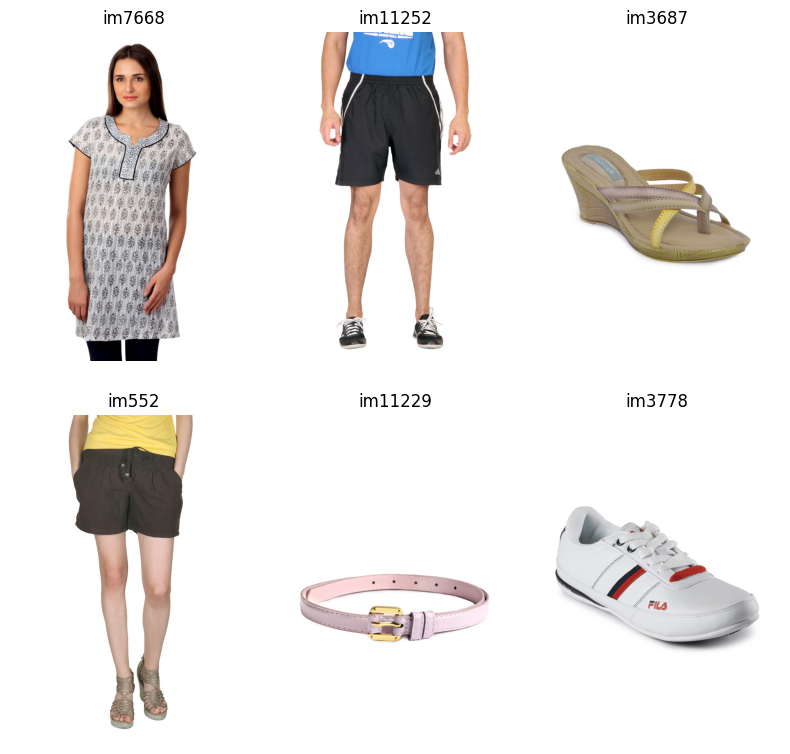

In [11]:
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.sample(6).iterrows()}
plot_figures(figures, 2, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
tf.__version__

'2.11.0'

In [15]:
img_width, img_height, _ = load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
i = 0
import time
start_time = time.time()
def get_embedding(model, img_name):
    global i, start_time
    if((i < 1000 and i%50 == 0) or i%200 == 0):
        print(i, "Time elapsed so far: {:.2f} minutes".format((time.time() - start_time) / 60))
    i += 1
    
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x,verbose=0).reshape(-1)

In [17]:
emb = get_embedding(model, df.iloc[59].image)
emb.shape

0 Time elapsed so far: 0.00 minutes


(2048,)

[0.49842936 4.991066   0.         ... 2.835719   4.693335   0.        ]


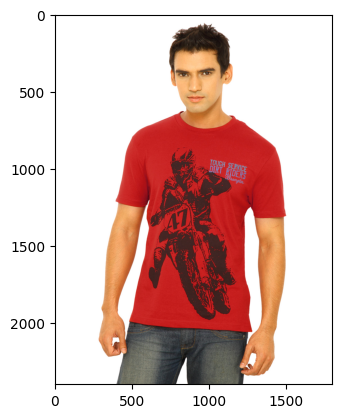

In [18]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[59].image,True), cv2.COLOR_BGR2RGB))
print(emb)

In [19]:
import dask.dataframe as dd

dask_df = dd.from_pandas(df, npartitions=32)

# Define the expected output type of your function
meta = pd.Series([], dtype=float)

In [20]:
dask_df['image']

Dask Series Structure:
npartitions=32
0        object
469         ...
          ...  
14532       ...
14999       ...
Name: image, dtype: object
Dask Name: getitem, 2 graph layers

In [21]:
import time
start_time = time.time()
i = 0

# Apply the function to each partition of the dataframe in parallel
dask_result = dask_df['image'].map(lambda img: get_embedding(model, img), meta=meta)

# Compute the result
result = dask_result.compute().reset_index(drop=True)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_11
...............vars
............activation_12
...............vars
............activation_13
...............vars
............activation_14
...............vars
............activation_15
...............vars
............activation_16
...............vars
............activation_17
...............vars
............activation_18
...............vars
............activation_19
...............vars
............activation_2
...............vars
............activation_20
...............vars
............activation_21
...............vars
............activation_22
...............vars
............activation_23
...............vars
............activation_24
...............vars
............activation_25
...............vars
............activation

In [22]:
print(result.shape)
result.head()

(14999,)


0    [0.0, 3.6514287, 0.0, 0.7522433, 0.0, 0.0, 4.1...
1    [1.8793472, 1.6008918, 0.09203294, 4.433068, 0...
2    [0.0, 0.3111956, 0.0, 3.808685, 0.4370315, 7.1...
3    [0.58801633, 9.894604, 0.0, 6.2953196, 1.78371...
4    [0.0, 1.8829764, 0.0, 5.1221185, 0.0, 0.0, 2.9...
Name: image, dtype: object

In [23]:
df_embds = result.apply(pd.Series)

In [24]:
print(df_embds.shape)
df_embds.head()

(14999, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.651429,0.000000,0.752243,0.000000,0.000000,4.103794,2.382154,2.472520,0.0,...,0.366400,0.000000,0.000000,6.000701,0.000000,0.000000,6.389898,4.246421,1.067716,1.671669
1,1.879347,1.600892,0.092033,4.433068,0.000000,0.000000,3.030764,8.530598,5.498654,0.0,...,2.808290,0.000000,3.923509,3.183098,0.000000,0.000000,4.244196,3.268897,2.271749,5.433375
2,0.000000,0.311196,0.000000,3.808685,0.437032,7.112500,0.000000,0.000000,0.000000,0.0,...,0.218202,7.861265,1.655924,0.000000,0.000000,0.000000,4.702983,0.000000,2.340576,0.000000
3,0.588016,9.894604,0.000000,6.295320,1.783711,1.913124,0.000000,13.309926,7.805786,0.0,...,22.434399,0.000000,0.000000,0.000000,2.565922,3.330479,0.594363,1.130465,3.084236,7.608909
4,0.000000,1.882976,0.000000,5.122118,0.000000,0.000000,2.950300,6.626852,1.606633,0.0,...,2.504942,0.000000,1.274126,3.484577,0.786352,0.000000,1.597870,2.515505,0.068360,0.000000


In [25]:
from scipy import sparse

# Convert DataFrame to a sparse matrix
sparse_matrix = sparse.csr_matrix(df_embds.values)

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_img.npz', sparse_matrix)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate the text columns into a single column
df['combined_text'] = [' '.join(row) for row in df[['gender', 'masterCategory', 'subCategory', 'articleType',
                                                     'baseColour', 'season', 'year', 'usage',
                                                     'productDisplayName']].values.astype(str)]


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined_text column
tfidf_embeddings = vectorizer.fit_transform(df['combined_text'])

# tfidf_embeddings is a sparse matrix containing the TF-IDF vectors
tfidf_embeddings

<14999x5074 sparse matrix of type '<class 'numpy.float64'>'
	with 169210 stored elements in Compressed Sparse Row format>

In [27]:
from scipy import sparse

# Save the sparse matrix to a file
sparse.save_npz('sparse_matrix_df_embds_tfidf.npz', tfidf_embeddings)

In [28]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_imgs = 1-pairwise_distances(df_embds, metric='cosine')
cosine_sim_imgs[:4, :4]

array([[1.        , 0.5789426 , 0.23815554, 0.49101025],
       [0.5789426 , 0.99999905, 0.2395134 , 0.72273487],
       [0.23815554, 0.2395134 , 1.        , 0.2201165 ],
       [0.49101025, 0.72273487, 0.2201165 , 1.        ]], dtype=float32)

In [29]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule Distance Matrix
cosine_sim_tfidf = 1-pairwise_distances(tfidf_embeddings, metric='cosine')
cosine_sim_tfidf[:4, :4]

array([[1.        , 0.18218686, 0.00698982, 0.08623057],
       [0.18218686, 1.        , 0.00593168, 0.08422119],
       [0.00698982, 0.00593168, 1.        , 0.00504161],
       [0.08623057, 0.08422119, 0.00504161, 1.        ]])

In [30]:
cosine_sim = cosine_sim_tfidf * 0.3 + cosine_sim_imgs * 0.7

In [33]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [34]:
get_recommender(200, df, top_n = 5)

(Int64Index([3644, 6374, 9386, 13561, 8112], dtype='int64'),
 [0.8107271252752029,
  0.792945546655632,
  0.7918312250641308,
  0.7731353742377296,
  0.772387601623272])

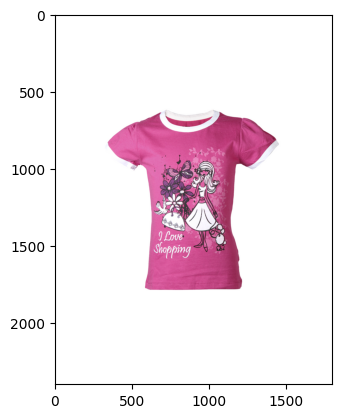

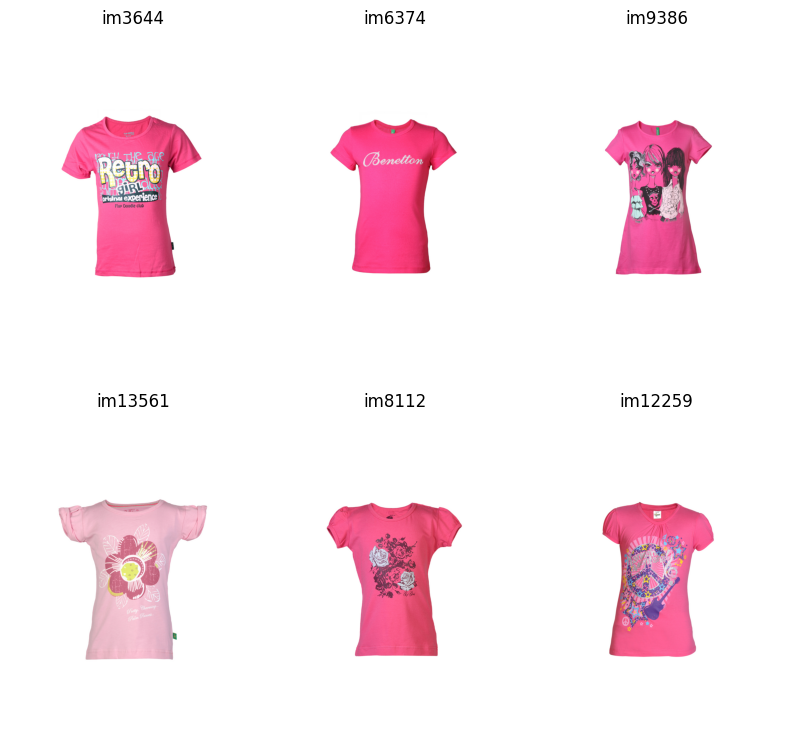

In [35]:
idx_ref = 200

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image,True), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image,True) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)